# Scanpy – Single-Cell Analysis of 3k PBMCs from 10x Genomics

#### This is a guided tutorial for analyzing data consist in 2,700 Peripheral Blood Mononuclear Cells (PBMCs) from a Healthy Donor and are freely available from 10x Genomics [[link]](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

### Prerequisites
- Install python libraries: numpy, pandas, scanpy, e.g., `$ pip install scanpy`.
- Install JupyterLab and launch a JupyterLab interface in a terminal via command `$ jupyterlab` [[link]](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html).

##### Import python libraries.

In [10]:
import numpy as np
import pandas as pd
import scanpy as sc

##### Show scanpy version.

In [11]:
sc.__version__

'1.6.0'

##### Set verbosity, logging level and figure DPI.

In [12]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


##### Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotions and different representations of the data.

In [13]:
adata = sc.read_10x_mtx(
    'pbmc3k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
     var_names='gene_symbols',                                           # use gene symbols for the variable names (variables-axis index)
     cache=True)                                                         # write a cache file for faster subsequent reading

... reading from cache file cache/pbmc3k_filtered_gene_bc_matrices-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [14]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Preprocessing

##### Low-quality libraries in scRNA-seq data can arise from a variety of sources such as cell damage during dissociation or failure in library preparation (e.g., inefficient reverse transcription or PCR amplification). These usually manifest as “cells” with low total counts, few expressed genes and high mitochondrial or spike-in proportions. These low-quality libraries are problematic as they can contribute to misleading results in downstream analyses.

##### Filter cells with less than 200 genes expressed; filter genes that are expressed in less than 3 cells.

In [15]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


##### Compute other QC metrics.

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

##### Create a violin plot of the following computed quality measures:
- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

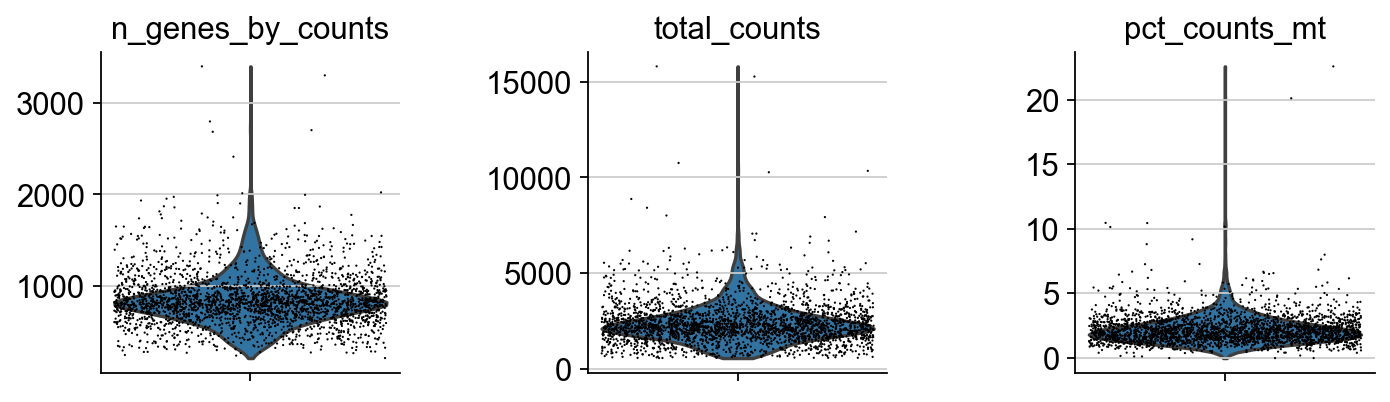

In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

##### Create two scatter QC plots:
- total counts vs mitochondrial gene count percentages
- total counts vs number of genes by counts

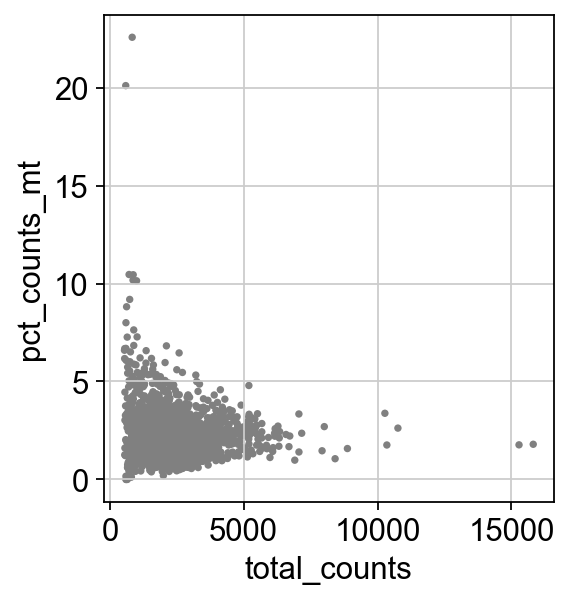

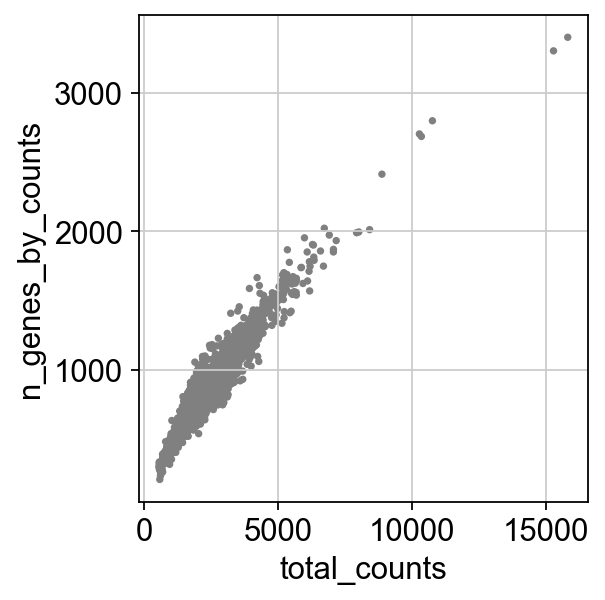

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

##### Remove cells that have too many mitochondrial genes expressed or too many total counts.

In [19]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

##### Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/lding/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


##### Logarithmize the data.

In [21]:
sc.pp.log1p(adata)

##### Identify highly-variable genes.

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


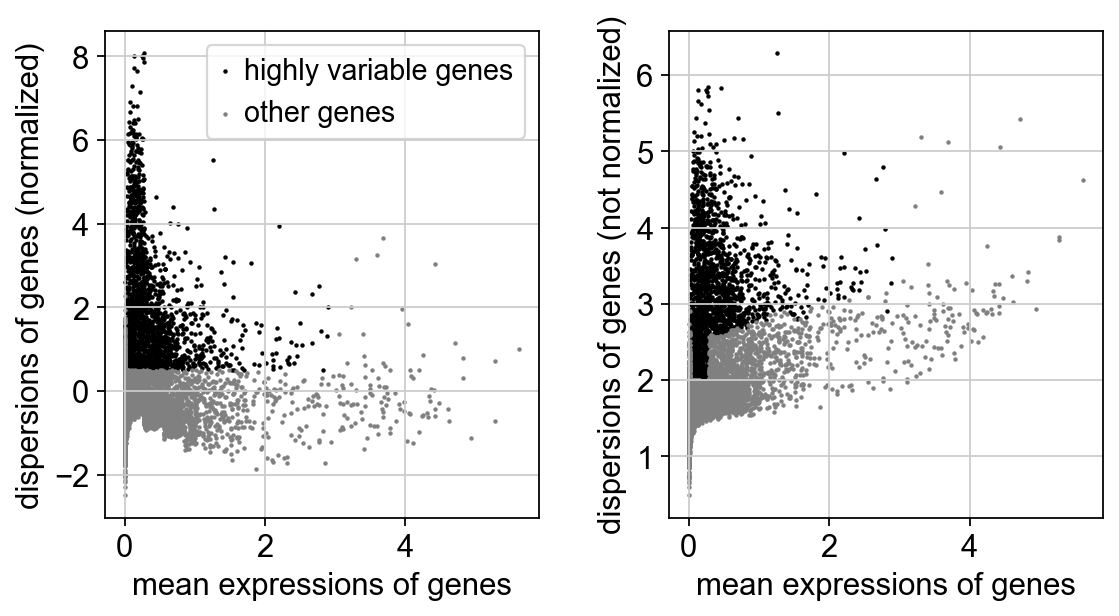

In [23]:
sc.pl.highly_variable_genes(adata)

##### Set the .raw attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [24]:
adata.raw = adata

##### Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance. Clip values exceeding standard deviation 10.

In [25]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:54)


### Linear Dimensional Reduction by Principal component analysis (PCA)

##### Run PCA to reveal the main axes of variation for denoising the data. Make a scatter plot.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


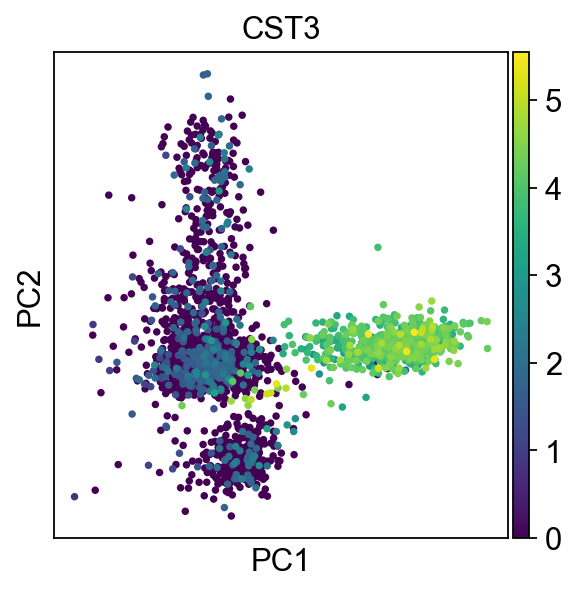

In [32]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

### Compute the Neighborhood Graph and Embed the Graph using UMAP

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


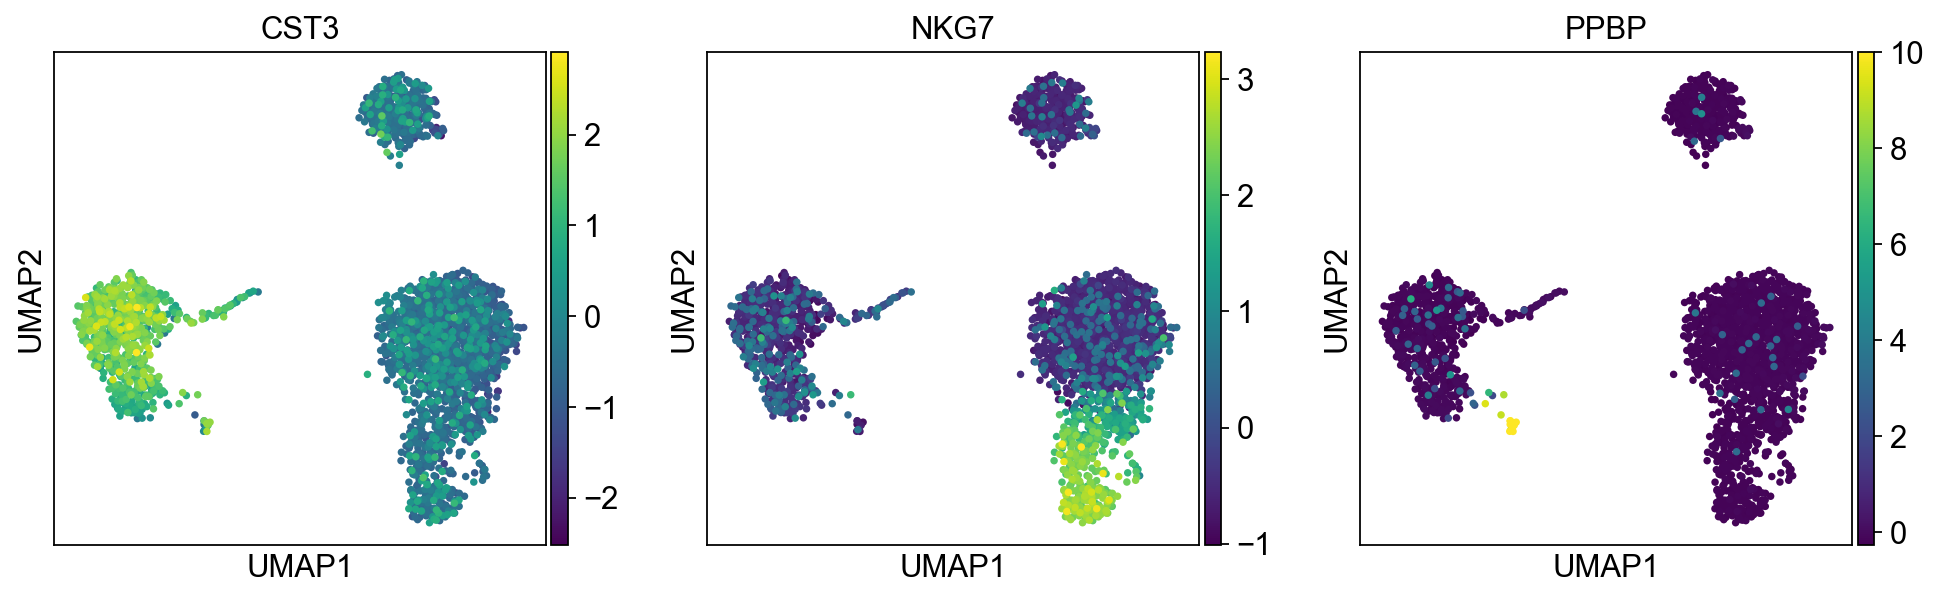

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

### Clustering the Neighborhood Graph

##### As Seurat and many others, Scanpy recommends the Leiden graph-clustering method (community detection based on optimizing modularity).

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


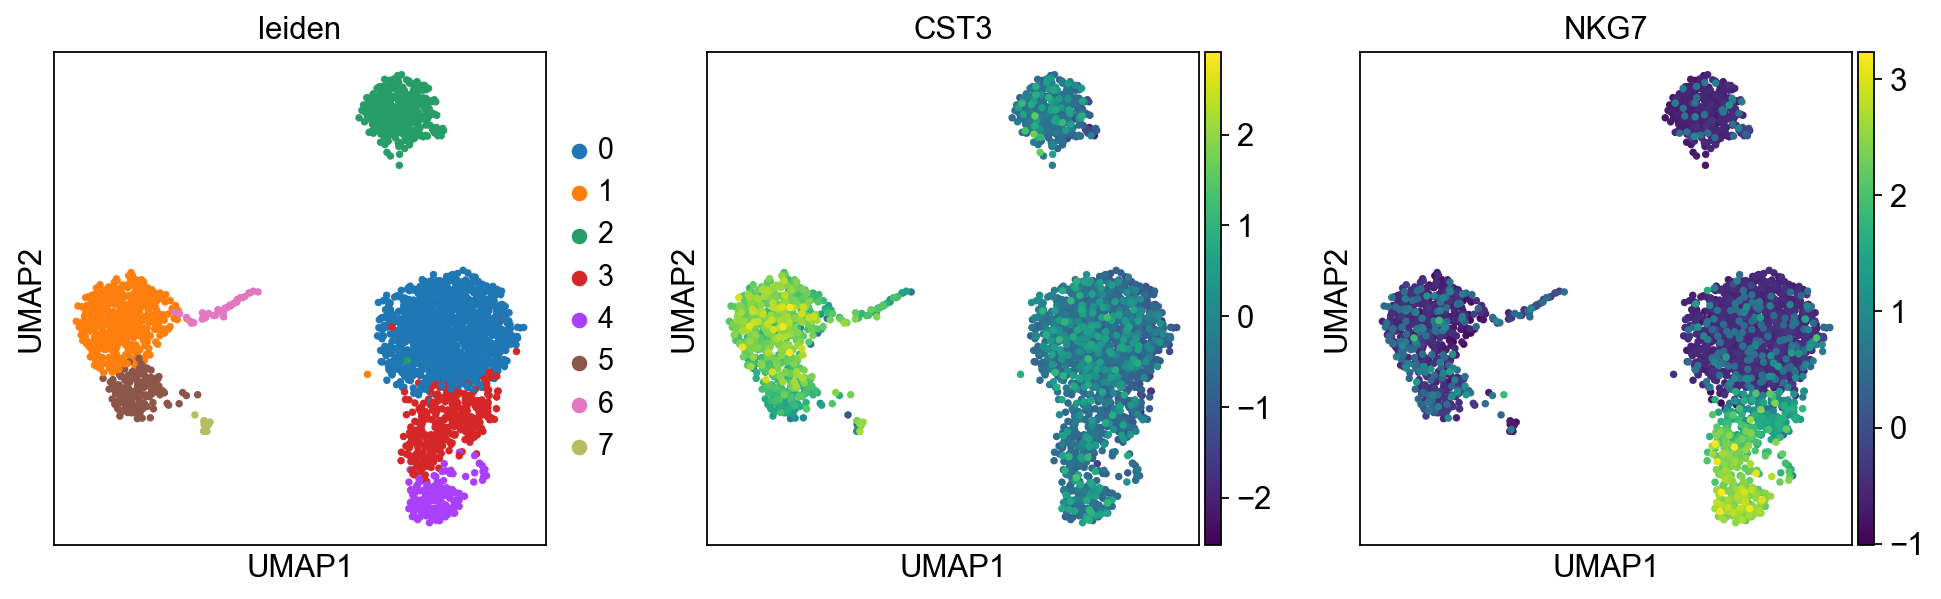

In [34]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'], use_raw=False)

### Finding Marker Genes for Each Cluster

##### User has the option to choose a method for differential testing. Wilcoxon rank-sum (Mann-Whitney-U) test is used here.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


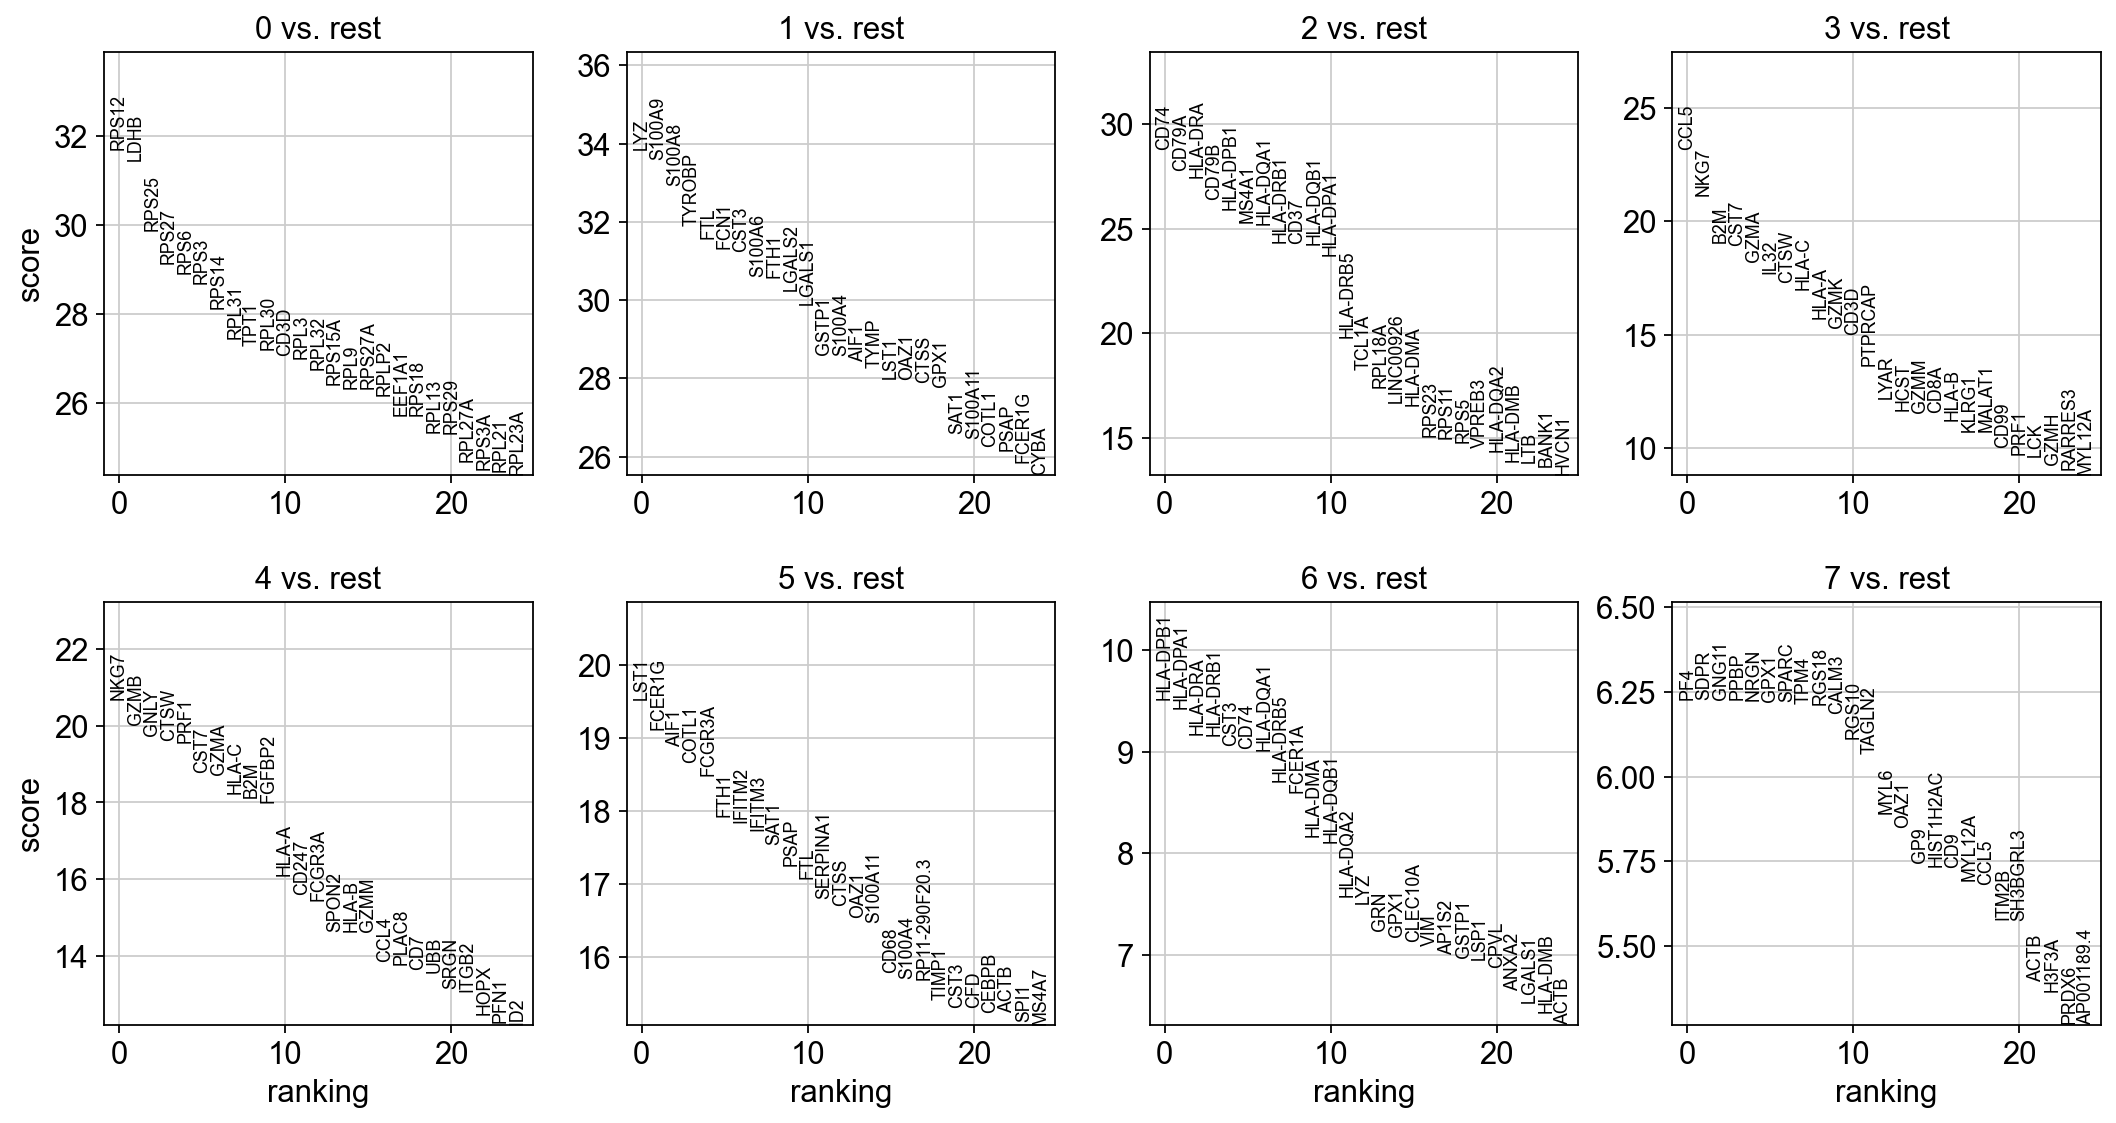

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

##### Compare a certain gene across groups.

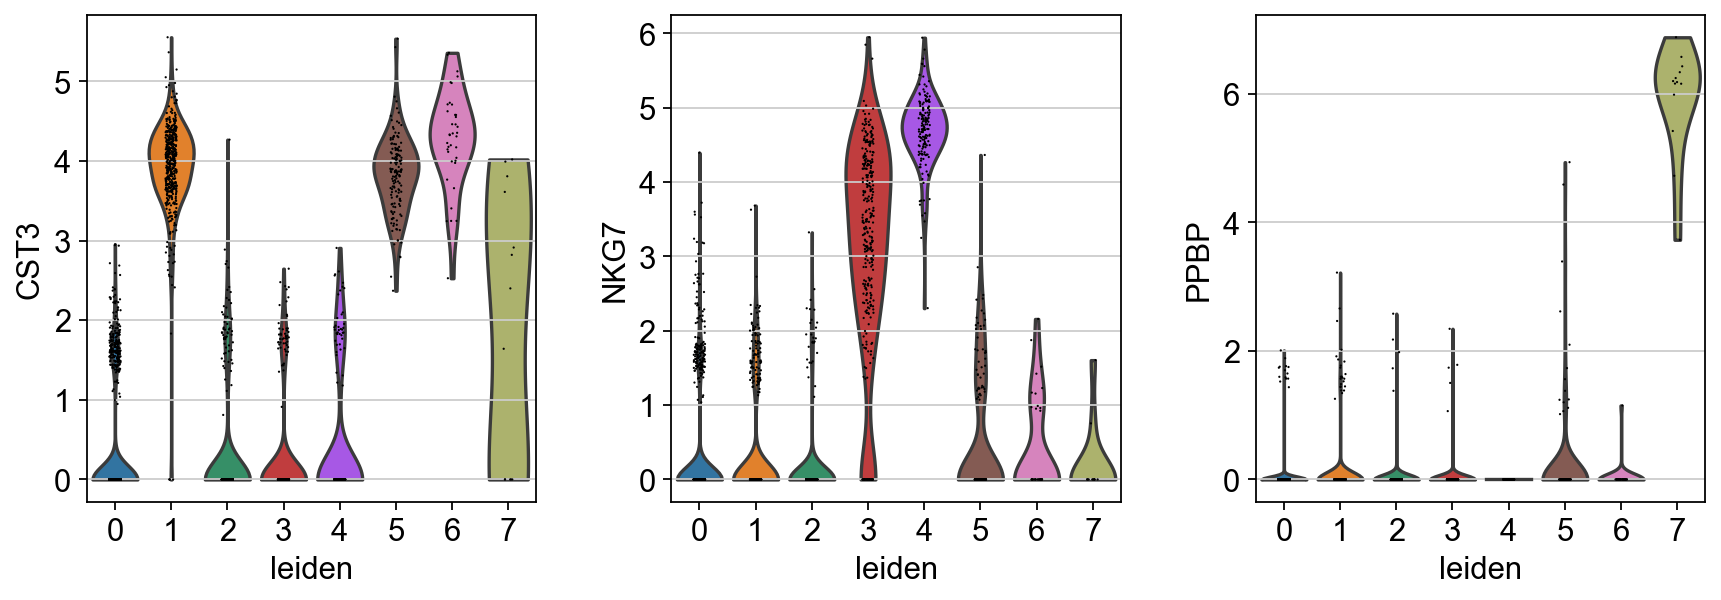

In [36]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

##### Mark the cell types.

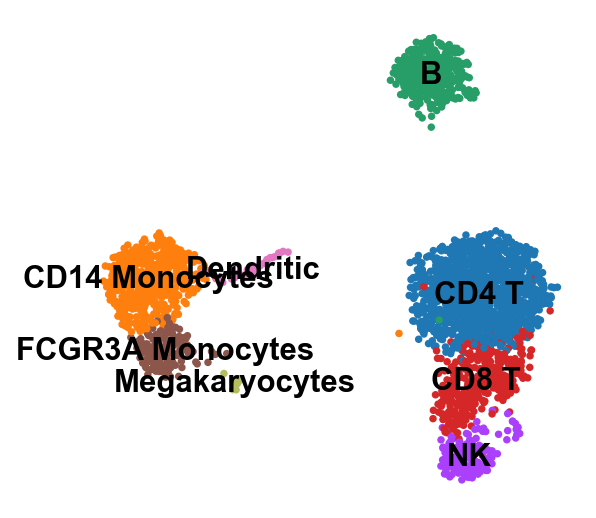

In [37]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

##### Visualize the marker genes.

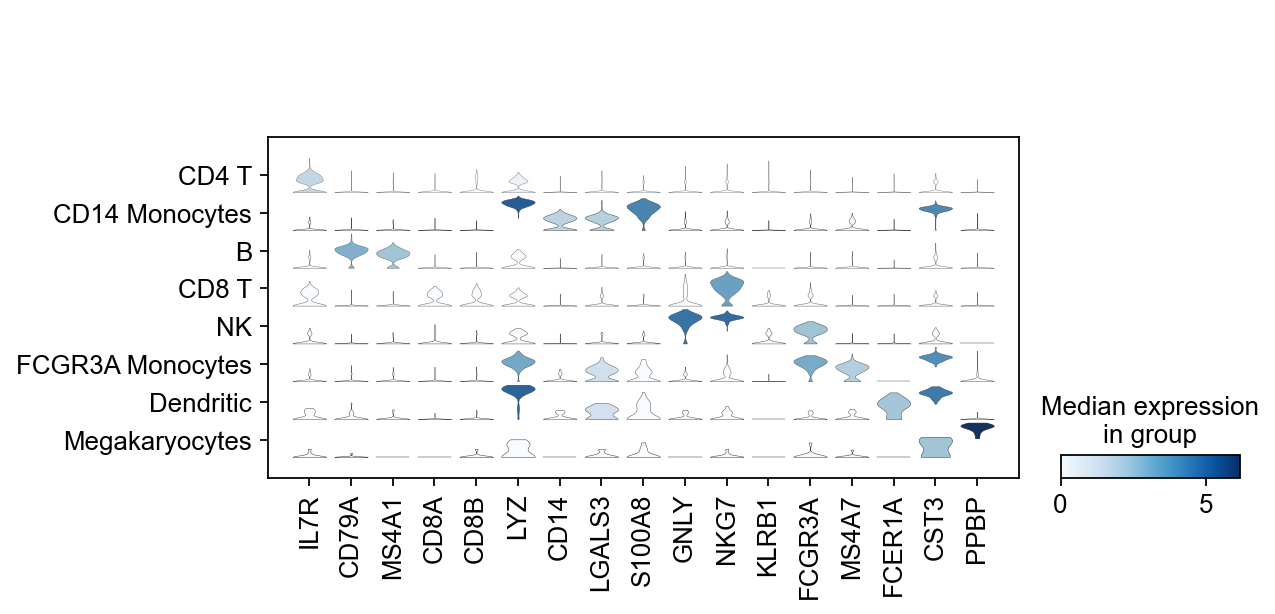

In [38]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

### Save the Analysis Results

##### During the course of this analysis, the AnnData accumlated the following annotations.

In [39]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [40]:
results_file = '/Users/lding/Documents/CMPB-Practicum/Scanpy/pbmc3k.h5ad'
adata.write(results_file, compression='gzip')

OSError: Unable to create file (unable to open file: name = '/Users/lding/Documents/CMPB-Practicum/Scanpy/pbmc3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)